In [9]:
from sys import stdout
from openmm.app import *
from openmm import *
from simtk.unit import *

import openmmtools as tools
import MDAnalysis as md
import nglview as ng
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

In [10]:
### 1. Choose a water model
h2o = "spce"
# h2o = "tip3p"
# h2o = "tip4p"
# h2o = "tip4pew"
# h2o = "tip5p"

### 2. Create initial coordinates and system
water = tools.testsystems.WaterBox(model=h2o,
                                  box_edge=2.5*nanometers)

### 2a. Save initial coordinates to file
output = open('water.pdb', 'w')
PDBFile.writeFile(water.topology, water.positions, output)
output.flush()

In [11]:
### 3. Choose parameters of the experiment: temperature, pressure and length
temperature = 320*kelvin
pressure = 1*atmosphere
simulationTime = 5*picosecond

### 3a. Simulation timestep, total number of steps and thermostat/barostat parameters
timeStep = 0.002*picoseconds
totalSteps = simulationTime / timeStep
frictionCoeff = 1/picosecond
nupdt = 25

### 4. Choose an integrator
integrator = LangevinIntegrator( temperature, frictionCoeff, timeStep )
water.system.addForce(MonteCarloBarostat( pressure , temperature , nupdt ) )

### 5 Create a simulation object
simulation = Simulation(water.topology, water.system, integrator)
simulation.context.setPositions(water.positions)
simulation.context. setVelocitiesToTemperature(temperature, 12345)

### 6. Set output for trajectory and thermodynamics data
simulation.reporters.append(DCDReporter('traj.dcd', 100))

### 7. Set output for thermodynamics data
simulation.reporters.append(StateDataReporter( "thermo.csv"
                                             , 10
                                             , step            = True
                                             , time            = True
                                             , potentialEnergy = True
                                             , temperature     = True
                                             , density         = True
                                             , volume          = True
                                             , separator       = ","
                                             ))


### 7a. Set screen output to monitor the simulation progress
simulation.reporters.append(StateDataReporter( stdout
                                             , int(totalSteps/10)
                                             , step            = True
                                             , progress        = True
                                             , remainingTime   = True
                                             , elapsedTime     = True
                                             , separator       = " "
                                             , totalSteps      = totalSteps
                                             ))


In [12]:
### 8. Run MD
simulation.step(totalSteps)

#"Progress (%)" "Step" "Elapsed Time (s)" "Time Remaining"
10.0% 250 4.6253204345703125e-05 --
20.0% 500 3.4581124782562256 0:27
30.0% 750 6.981318235397339 0:24
40.0% 1000 10.449214458465576 0:20
50.0% 1250 13.749690055847168 0:17
60.0% 1500 17.153161764144897 0:13
70.0% 1750 20.482667922973633 0:10
80.0% 2000 23.880424976348877 0:06
90.0% 2250 27.27147603034973 0:03
100.0% 2500 30.779780387878418 0:00


In [13]:
### 9. Visualization
sys = md.Universe("water.pdb", 'traj.dcd')
ng.show_mdanalysis(sys, gui=True)

NGLWidget(max_frame=24)

In [14]:
### 10. Load the thermodynamic data in a dataframe
data = pd.read_csv("thermo.csv")
print(data.head())
print(data.tail())

   #"Step"  Time (ps)  Potential Energy (kJ/mole)  Temperature (K)  \
0       10       0.02               -17783.534230      1225.613995   
1       20       0.04               -17708.083555      1180.506950   
2       30       0.06               -17080.726192      1097.187048   
3       40       0.08               -16633.966228      1034.186229   
4       50       0.10               -16773.478110      1012.412426   

   Box Volume (nm^3)  Density (g/mL)  
0          15.625000        0.984089  
1          15.625000        0.984089  
2          15.625000        0.984089  
3          15.625000        0.984089  
4          15.777909        0.974552  
     #"Step"  Time (ps)  Potential Energy (kJ/mole)  Temperature (K)  \
245     2460       4.92               -22995.403604       339.990995   
246     2470       4.94               -22851.765985       327.207282   
247     2480       4.96               -22860.018163       329.966548   
248     2490       4.98               -22825.880684      

Slope              : 0.007185018100884931
Intercept          : 0.9430483715264623


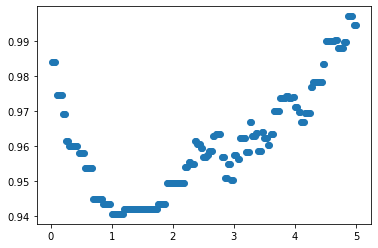

In [15]:
x = data["Time (ps)"]
y = data["Density (g/mL)"]
plt.scatter(x,y)

xmin = np.min(x)
xmax = np.max(x)
fit = np.polyfit(x,y,1)
print("Slope              :",fit[0])
print("Intercept          :",fit[1])
# print("Drift              :",fit[0]*(xmax-xmin))

In [16]:
average = np.mean(data["Density (g/mL)"])
stderr = np.std(data["Density (g/mL)"]) / np.sqrt(np.size(data["Density (g/mL)"]))
print(average,stderr)

0.9610827669596828 0.0009728149213491968
